In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import gym
import random
from collections import namedtuple,deque
from scipy.special import softmax
import matplotlib.pyplot as plt
torch.manual_seed(42)

In [2]:
class Net(nn.Module):
  def __init__(self, params):
    super().__init__()
    self.input_size = params['input_size']
    self.output_size = params['output_size']
    self.hidden_layers = params['hidden_layers']

    self.layers = nn.ModuleList()

    cdim = self.input_size
    for hdim in self.hidden_layers:
      self.layers.append(nn.Linear(cdim, hdim))
      self.layers.append(nn.ReLU())
      cdim = hdim
    
    self.layers.append(nn.Linear(cdim, self.output_size))

  def forward(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

# DQN
## Constructing Replay Buffer

In [84]:
class ReplayBuffer():
  def __init__(self, buffer_size, batch_size, seed = 42):
    self.buffer_size = buffer_size
    self.batch_size = batch_size
    self.memory = []
    self.seed = random.seed(seed)
    self.experience = namedtuple("Experience", field_names=('state', 'action', 'reward', 'next_state', 'done'))

  def add(self, state, action, reward, next_state, done):
    exp = self.experience(state, action, reward, next_state, done)
    self.memory.append(exp)
    
  def sample(self):
    exps = random.sample(self.memory, k=self.batch_size)

    states = torch.from_numpy(np.vstack([exp.state for exp in exps if exp.state is not None])).float()
    actions = torch.from_numpy(np.vstack([exp.action for exp in exps if exp.action is not None])).long()
    rewards = torch.from_numpy(np.vstack([exp.reward for exp in exps if exp.reward is not None])).float()
    next_states = torch.from_numpy(np.vstack([exp.next_state for exp in exps if exp.next_state is not None])).float()
    dones = torch.from_numpy(np.vstack([exp.done for exp in exps if exp.done is not None])).float()

    return (states, actions, rewards, next_states, dones)
  
  def len_mem(self):
    return len(self.memory)

## Agent 

In [85]:
class DQN_Agent():
  def __init__(self, net_params, gamma, buffer_size, batch_size, UPDATE_EVERY, policy='e-greedy', seed= 42):
    self.net_params = net_params
    self.gamma = gamma
    self.buffer_size = buffer_size
    self.batch_size = batch_size
    self.UPDATE_EVERY = UPDATE_EVERY
    self.policy = policy
    self.seed  = np.random.seed(seed)

    self.t_step = 0

    self.memory = ReplayBuffer(self.buffer_size, self.batch_size)
    self.Q_network = Net(net_params)
    self.Q_network_target = Net(net_params)
    self.loss_func = nn.MSELoss()
    self.optimizer = torch.optim.Adam(self.Q_network.parameters(), lr = net_params['lr'])

  def learn(self, experience):
    states, actions, rewards, next_states, dones = experience
    Q_, _ = torch.max(self.Q_network_target(next_states).detach(), axis = 1)
    Q_target = rewards + self.gamma * Q_.unsqueeze(1)*(1 - dones)
    Q = self.Q_network(states).gather(1, actions)

    loss = self.loss_func(Q_target, Q)
    self.optimizer.zero_grad()
    loss.backward()

    for param in self.Q_network.parameters():
      param.grad.data.clamp(-1 ,1)
    self.optimizer.step()

  def step(self, state, action,  reward, next_state, done):
    self.memory.add(state, action, reward, next_state, done)

    if self.memory.len_mem() >= self.batch_size:
      exps = self.memory.sample()
      self.learn(exps)

    self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
    if self.t_step == 0:
      self.Q_network_target.load_state_dict(self.Q_network.state_dict())
    
  def act(self, states, eps):
    states = torch.from_numpy(states).float().unsqueeze(0)

    self.Q_network.eval()
    with torch.no_grad():
      Q_values = self.Q_network(states)
    self.Q_network.train()

    if self.policy == 'e-greedy':
      if random.random() > eps:
        return np.argmax(Q_values, axis = 1).item()
      else:
        return np.random.choice(np.arange(self.net_params['output_size']))
    else:
      return np.random.choice(np.arange(self.net_params['output_size']), softmax(Q_values))

## Training function 

In [86]:
def DQN(env, thresh, params, num_episodes = 10000, num_steps = 1000, eps_start = 1.0, eps_stop = 0.01, eps_decay = 0.995):
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.n

  hidden_layers = params['hlayers']
  gamma = params['gamma']
  buffer_size = params['buffer_size']
  batch_size = params['batch_size']
  update_every = params['update_every']
  lr = params['LR']
  policy = params['policy']

  net_params = {
      'input_size': state_size,
      'hidden_layers': hidden_layers,
      'output_size': action_size,
      'lr'  : lr
  }

  scores = []
  avg_scores = []
  scores_window = deque(maxlen = 10)
  scores_printing = deque(maxlen=100)

  agent = DQN_Agent(net_params, gamma, buffer_size, batch_size, update_every, policy)
  eps = eps_start

  for epi in range(num_episodes):
    state = env.reset()
    score = 0

    for step in range(num_steps):
      action = agent.act(state, eps)
      next_state, reward, done, _ = env.step(action)
      agent.step(state, action, reward, next_state, done)
      state = next_state
      score += reward
      if done:
        break

    scores_window.append(score)
    scores_printing.append(score)

    eps = max(eps_stop, eps * eps_decay)

    print('\rEpisode {}\tAverage Score: {:.2f}, Step:{}'.format(epi, np.mean(scores_window), step), end="")
    if epi % 10 == 0: 
      avg_scores.append(np.mean(scores_printing))        
    if epi % 100 == 0: 
      print('\rEpisode {}\tAverage Score: {:.2f}'.format(epi, np.mean(scores_window)))
    if np.mean(scores_window)>= thresh:
      print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(epi, np.mean(scores_window)))
      break
    scores.append(score)
  return (scores, avg_scores, agent, epi)

# Acrobot-v1

Threshold reward: -100 (From GYM documentation)

Initial parameters: 
* Architecture: 64, 64
* Buffer Size: 1e+5
* Batch Size: 64
* Learning Rate: 5e-4
* Update Frequency: 20
* Discount factor: 0.995

Num of episodes to reach threshold: 270

In [87]:
env = gym.make('Acrobot-v1')
threshold_value = -100.0

params ={
    'hlayers' : [64, 64],
    'gamma' : 0.99,
    'buffer_size' : 1e+5,
    'batch_size' : 64,
    'LR': 5e-4,
    'policy' : 'e-greedy',
    'update_every' : 20
}

scores, avg_scores, acrobot_dqn, epi = DQN(env, threshold_value, params)
plt.plot(range(len(avg_scores)), avg_scores)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 0")
plt.show()

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 0	Average Score: -500.00
Episode 3	Average Score: -500.00, Step:499

KeyboardInterrupt: ignored

1) Configuration 1
* Architecture: 128, 128
* Buffer Size: 1e+5
* Batch Size: 64
* Learning Rate: 5e-4
* Update Frequency: 20
* Discount factor: 0.995

Num. of episodes: 285

Episode 0	Average Score: -500.00
Episode 100	Average Score: -180.10
Episode 200	Average Score: -119.90
Episode 296	Average Score: -100.00
Environment solved in 296 episodes!	Average Score: -100.00


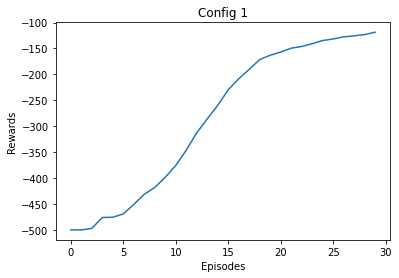

In [ ]:
params1 ={
    'hlayers' : [128, 128],
    'gamma' : 0.99,
    'buffer_size' : 1e+5,
    'batch_size' : 64,
    'LR' : 5e-4,
    'policy' : 'e-greedy',
    'update_every' : 20
}


scores1, avg_score1, acrobot_dqn1, epi1 = DQN(env, threshold_value, params1)
plt.plot(range(len(avg_score1)), avg_score1)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 1")
plt.show()

2) Configuration 2
* Architecture: 128, 64
* Buffer Size: 1e+5
* Batch Size: 64
* Learning Rate: 5e-4
* Update Frequency: 20
* Discount factor: 0.995

Num. of episodes: 325

Episode 0	Average Score: -500.00
Episode 100	Average Score: -203.30
Episode 200	Average Score: -125.70
Episode 263	Average Score: -99.30
Environment solved in 263 episodes!	Average Score: -99.30


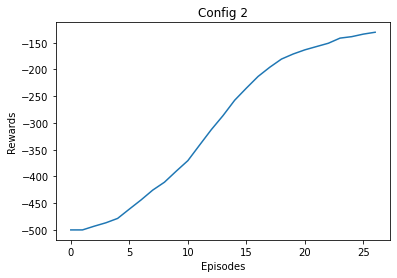

In [ ]:
params2 ={
    'hlayers' : [128, 64],
    'gamma' : 0.99,
    'buffer_size' : 1e+5,
    'batch_size' : 64,
    'LR' : 5e-4,
    'policy': 'e-greedy',
    'update_every' : 20
}

scores2, avg_scores2, acrobot_dqn2, epi2 = DQN(env, threshold_value, params2)
plt.plot(range(len(avg_scores2)), avg_scores2)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 2")
plt.show()

3) Configuration 3
* Architecture: 512, 128
* Buffer Size: 1e+5
* Batch Size: 64
* Learning Rate: 5e-4
* Update Frequency: 20
* Discount factor: 0.995

Num. of episodes: 269

Episode 0	Average Score: -500.00
Episode 100	Average Score: -183.00
Episode 200	Average Score: -138.20
Episode 283	Average Score: -99.30
Environment solved in 283 episodes!	Average Score: -99.30


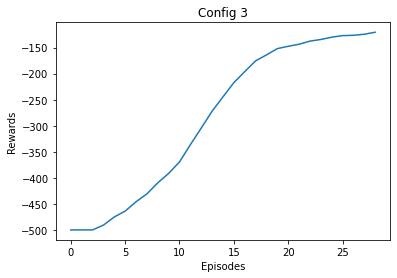

In [ ]:
params3 ={
    'hlayers' : [512, 128],

    'gamma' : 0.99,
    'buffer_size' : 1e+5,
    'batch_size' : 64,
    'LR': 5e-4,
    'policy':'e-greedy',
    'update_every' : 20
}

scores3, avg_scores3, acrobot_dqn3, epi3 = DQN(env, threshold_value, params3)
plt.plot(range(len(avg_scores3)), avg_scores3)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 3")
plt.show()

4) Configuration 4
* Architecture: 512, 512
* Buffer Size: 1e+5
* Batch Size: 64
* Learning Rate: 5e-4
* Update Frequency: 20
* Discount factor: 0.995

Num. of episodes: 321

Episode 0	Average Score: -500.00
Episode 100	Average Score: -201.70
Episode 200	Average Score: -137.00
Episode 275	Average Score: -99.40
Environment solved in 275 episodes!	Average Score: -99.40


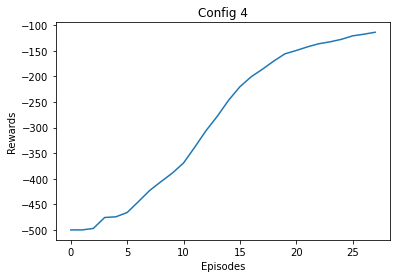

In [ ]:
params4 ={
    'hlayers' : [512, 512],
    'gamma' : 0.99,
    'buffer_size' : 1e+5,
    'batch_size' : 64,
    'LR':5e-4,
    'policy' : 'e-greedy',
    'update_every' : 20
}

scores4, avg_scores4, acrobot_dqn4, epi4 = DQN(env, threshold_value, params4)
plt.plot(range(len(avg_scores4)), avg_scores4)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 4")
plt.show()

5) Configuration 5
* Architecture: 128, 128
* Buffer Size: 1e+5
* Batch Size: 128
* Learning Rate: 5e-4
* Update Frequency: 20
* Discount factor: 0.995

Num. of episodes: 242

Episode 0	Average Score: -500.00
Episode 100	Average Score: -213.90
Episode 200	Average Score: -133.30
Episode 300	Average Score: -116.20
Episode 333	Average Score: -98.50
Environment solved in 333 episodes!	Average Score: -98.50


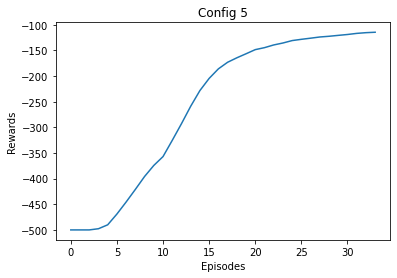

In [ ]:
params5 ={
    'hlayers' : [128, 128],
    'gamma' : 0.99,
    'buffer_size' : 1e+5,
    'batch_size' : 128,
    'LR' : 5e-4,
    'policy' : 'e-greedy',
    'update_every' : 20
}

scores5, avg_scores5, acrobot_dqn5, epi5 = DQN(env, threshold_value, params5)
plt.plot(range(len(avg_scores5)), avg_scores5)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 5")
plt.show()

6) Configuration 6
* Architecture: 128, 128
* Buffer Size: 1e+5
* Batch Size: 32
* Learning Rate: 5e-4
* Update Frequency: 20
* Discount factor: 0.995

Num. of episodes: 331

Episode 0	Average Score: -500.00
Episode 100	Average Score: -194.30
Episode 200	Average Score: -138.60
Episode 300	Average Score: -127.60
Episode 351	Average Score: -98.40
Environment solved in 351 episodes!	Average Score: -98.40


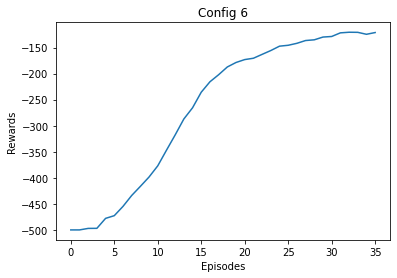

In [ ]:
params6 ={
    'hlayers' : [128, 128],
    'gamma' : 0.99,
    'buffer_size' : 1e+5,
    'batch_size' : 32,
    'LR' : 5e-4,
    'policy': 'e-greedy',
    'update_every' : 20
}

scores6,avg_scores6, acrobot_dqn6, epi6 = DQN(env, threshold_value, params6)
plt.plot(range(len(avg_scores6)), avg_scores6)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 6")
plt.show()

7) Configuration 7
* Architecture: 128, 128
* Buffer Size: 1e+5
* Batch Size: 64
* Learning Rate: 5e-4
* Update Frequency: 15
* Discount factor: 0.995

Num. of episodes: 333

Episode 0	Average Score: -500.00
Episode 100	Average Score: -234.30
Episode 200	Average Score: -139.80
Episode 283	Average Score: -99.80
Environment solved in 283 episodes!	Average Score: -99.80


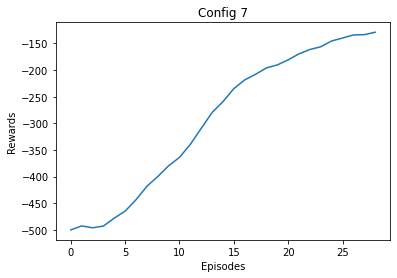

In [ ]:
params7 ={
    'hlayers' : [128, 128],
    'gamma' : 0.99,
    'buffer_size' : 1e+5,
    'batch_size' : 64,
    'LR' : 5e-4,
    'policy' : 'e-greedy',
    'update_every' : 15
}

scores7, avg_scores7, acrobot_dqn7, epi7 = DQN(env, threshold_value, params7)
plt.plot(range(len(avg_scores7)), avg_scores7)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 7")
plt.show()

8) Configuration 8
* Architecture: 128, 128
* Buffer Size: 1e+5
* Batch Size: 64
* Learning Rate: 5e-4
* Update Frequency: 25
* Discount factor: 0.995

Num. of episodes: 278

Episode 0	Average Score: -500.00
Episode 100	Average Score: -181.70
Episode 200	Average Score: -117.50
Episode 237	Average Score: -99.40
Environment solved in 237 episodes!	Average Score: -99.40


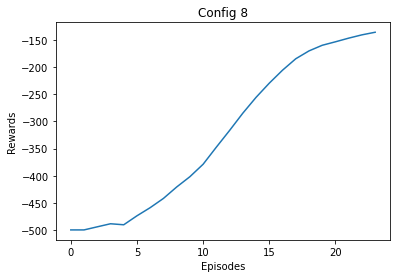

In [ ]:
params8 ={
    'hlayers' : [128, 128],
    'gamma' : 0.99,
    'buffer_size' : 1e+5,
    'batch_size' : 64,
    'LR' : 5e-4,
    'policy' : 'e-greedy',
    'update_every' : 25
}

scores8, avg_scores8, acrobot_dqn8, epi8 = DQN(env, threshold_value, params8)
plt.plot(range(len(avg_scores8)), avg_scores8)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 8")
plt.show()

9) Configuration 9
* Architecture: 128, 128
* Buffer Size: 1e+5
* Batch Size: 64
* Learning Rate: 5e-3
* Update Frequency: 20
* Discount factor: 0.995

Num. of episodes: 412

Episode 0	Average Score: -500.00
Episode 100	Average Score: -209.40
Episode 200	Average Score: -148.20
Episode 300	Average Score: -121.20
Episode 400	Average Score: -111.00
Episode 418	Average Score: -98.30
Environment solved in 418 episodes!	Average Score: -98.30


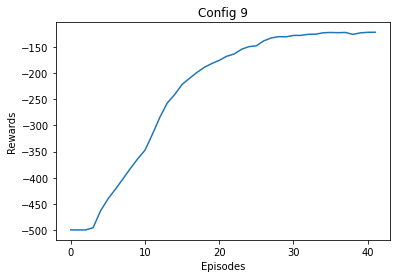

In [ ]:
params9 ={
    'hlayers' : [128, 128],
    'gamma' : 0.99,
    'buffer_size' : 1e+5,
    'batch_size' : 64,
    'LR' : 5e-3,
    'policy' : 'e-greedy',
    'update_every' : 25
}

scores9, avg_scores9, acrobot_dqn9, epi9 = DQN(env, threshold_value, params9)
plt.plot(range(len(avg_scores9)), avg_scores9)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 9")
plt.show()

10) Configuration 10
* Architecture: 128, 128
* Buffer Size: 1e+5
* Batch Size: 64
* Learning Rate: 1e-3
* Update Frequency: 20
* Discount factor: 0.995

Num. of episodes: 265

Episode 0	Average Score: -500.00
Episode 100	Average Score: -206.20
Episode 200	Average Score: -118.40
Episode 279	Average Score: -98.40
Environment solved in 279 episodes!	Average Score: -98.40


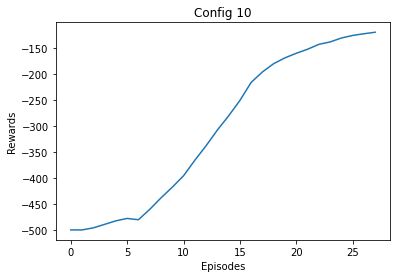

In [ ]:
params10 ={
    'hlayers' : [128, 128],
    'gamma' : 0.99,
    'buffer_size' : 1e+5,
    'batch_size' : 64,
    'LR' : 1e-4,
    'policy' : 'e-greedy',
    'update_every' : 20
}

scores10, avg_scores10, acrobot_dqn10, epi10 = DQN(env, threshold_value, params10)
plt.plot(range(len(avg_scores10)), avg_scores10)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 10")
plt.show()

11) Configuration 11
* Architecture: 128, 128
* Buffer Size: 1e+5
* Batch Size: 64
* Learning Rate: 1e-2
* Update Frequency: 25
* Discount factor: 0.995

Num. of episodes: 383

Episode 0	Average Score: -500.00
Episode 100	Average Score: -215.90
Episode 200	Average Score: -137.80
Episode 300	Average Score: -175.60
Episode 400	Average Score: -116.30
Episode 459	Average Score: -96.40
Environment solved in 459 episodes!	Average Score: -96.40


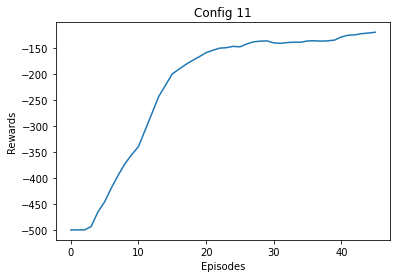

In [ ]:
params11 ={
    'hlayers' : [128, 128],
    'gamma' : 0.995,
    'buffer_size' : 1e+5,
    'batch_size' : 64,
    'LR' : 1e-5,
    'policy': 'e-greedy',
    'update_every' : 20
  
}

scores11, avg_scores11, acrobot_dqn11, epi11 = DQN(env, threshold_value, params11)
plt.plot(range(len(avg_scores11)), avg_scores11)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 11")
plt.show()

12) Configuration 12
* Architecture: 32, 32
* Buffer Size: 1e+5
* Batch Size: 16
* Learning Rate: 5e-4
* Update Frequency: 20
* Discount factor: 0.995

Num. of episodes: 326

In [ ]:
params12 ={
    'hlayers' : [512, 512],
    'gamma' : 0.995,
    'buffer_size' : 1e+5,
    'batch_size' : 16,
    'LR' : 5e-4,
    'policy' : 'e-greedy',
    'update_every' : 20
}

scores12, avg_scores12, acrobot_dqn12, epi12 = DQN(env, threshold_value, params12)
plt.plot(range(len(avg_scores12)), avg_scores12)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 12")
plt.show()

Episode 0	Average Score: -500.00
Episode 100	Average Score: -258.90
Episode 200	Average Score: -161.70
Episode 205	Average Score: -156.40

The best parameters for Acrobot-v1
* Network Architecture: 128, 128
* Discount Factor: 0.995
* LR : 5e-4
* Buffer Size: 1e+5
* Batch Size: 128
* Update Frequency: 25

The least achieved number of episodes: 242

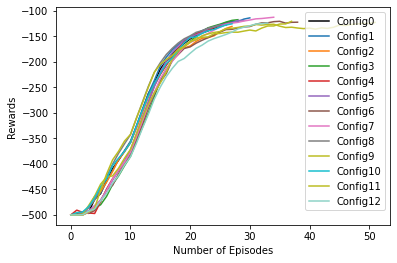

In [ ]:
scores_ = [scores, scores1, scores2, scores3,scores4,scores5,scores6,scores7,scores8,scores9,scores10,scores11,scores12]
colors = ['#000000','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#bcbd22', '#8dd3c7']

for i in range(len(scores_)):
  plt.plot(range(len(scores_[i])), scores_[i], color=colors[i], label=f'Config{i}')
plt.legend()
plt.xlabel('Number of Episodes')
plt.ylabel('Rewards')
plt.show()

## CartPole - V1
Threshold reward: 475(from GYM documentation)


Initial parameters: 
* Architecture: 64, 64
* Buffer Size: 1e+5
* Batch Size: 64
* Learning Rate: 5e-4
* Update Frequency: 20
* Discount factor: 0.995

Num of episodes to reach threshold: 260

Episode 0	Average Score: 14.00
Episode 100	Average Score: 39.90
Episode 200	Average Score: 126.60
Episode 300	Average Score: 140.20
Episode 400	Average Score: 121.60
Episode 473	Average Score: 481.90, Step:433
Environment solved in 473 episodes!	Average Score: 481.90


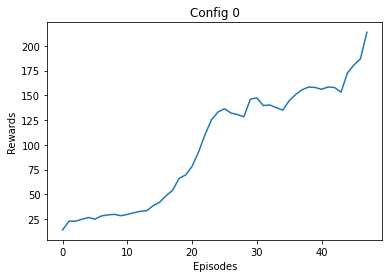

In [88]:
env_cp = gym.make("CartPole-v1")
threshold_value_cp = 475.0

params = {
    'hlayers' : [64, 64],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 64,
    'LR' : 5e-3,
    'policy' : 'e-greedy',
    'update_every' : 20
}

scores_cp, avg_scores_cp, cartpole_dqn, episode = DQN(env_cp, threshold_value_cp, params)
plt.plot(range(len(avg_scores_cp)), avg_scores_cp)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 0")
plt.show()

1) Configuration 1
* Network Architecture: 128, 128
* Buffer Size: 1e+5
* Batch Size: 64
* Learning rate: 5e-4
* Update Frequency : 20

Num of episodes: 235

In [ ]:
params_cp1 = {
    'hlayers' : [128, 128],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 64,
    'LR' : 5e-4,
    'policy' : 'e-greedy',
    'update_every' : 20
}

scores1_cp, avg_scores1_cp, cartpole_dqn1, episode1 = DQN(env_cp, threshold_value_cp, params_cp1)
plt.plot(range(len(avg_scores1_cp)), avg_scores1_cp)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 1")
plt.show()

2) Configuration 2
* Network Architecture: 512, 512
* Buffer Size: 1e+5
* Batch Size: 64
* Learning rate: 5e-4
* Update Frequency : 20

Num of episodes: 334

In [ ]:
params_cp2 = {
    'hlayers' : [512, 512],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 64,
    'LR' : 5e-4,
    'policy' : 'e-greedy',
    'update_every' : 20
}

scores2_cp, avg_scores2_cp, cartpole_dqn2, episode2 = DQN(env_cp, threshold_value_cp, params_cp2)
plt.plot(range(len(avg_scores2_cp)), avg_scores2_cp)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 2")
plt.show()

3) Configuration 3
* Network Architecture: 32, 32
* Buffer Size: 1e+5
* Batch Size: 64
* Learning rate: 5e-4
* Update Frequency : 20

Num of episodes: 247

In [ ]:
params_cp3 = {
    'hlayers' : [32, 32],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 64,
    'LR' : 5e-4,
    'policy':'e-greedy',
    'update_every' : 20
}

scores3_cp, avg_scores3_cp, cartpole_dqn3, episode3 = DQN(env_cp, threshold_value_cp, params_cp3)
plt.plot(range(len(avg_scores3_cp)), avg_scores3_cp)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 3")
plt.show()

4) Configuration 4
* Network Architecture: 128, 128
* Buffer Size: 1e+5
* Batch Size: 128
* Learning rate: 5e-4
* Update Frequency : 20

Num of episodes: 356

In [ ]:
params_cp4 = {
    'hlayers' : [128, 128],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 128,
    'LR' : 5e-4,
    'policy': 'e-greedy',
    'update_every' : 20
}

scores4_cp, avg_scores4_cp, cartpole_dqn4, episode4 = DQN(env_cp, threshold_value_cp, params_cp4)
plt.plot(range(len(avg_scores4_cp)), avg_scores4_cp)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 4")
plt.show()

5) Configuration 5
* Network Architecture: 128, 128
* Buffer Size: 1e+5
* Batch Size: 16
* Learning rate: 5e-4
* Update Frequency : 20

Num of episodes: 268

In [ ]:
params_cp5 = {
    'hlayers' : [128, 128],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 16,
    'LR' : 5e-4,
    'policy': 'e-greedy',
    'update_every' : 20
}

scores5_cp, avg_scores5_cp, cartpole_dqn5, episode5 = DQN(env_cp, threshold_value_cp, params_cp5)
plt.plot(range(len(avg_scores5_cp)), avg_scores5_cp)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 5")
plt.show()

6) Configuration 6
* Network Architecture: 128, 128
* Buffer Size: 1e+5
* Batch Size: 32
* Learning rate: 5e-4
* Update Frequency : 20

Num of episodes: 266

In [ ]:
params_cp6 = {
    'hlayers' : [128, 128],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 32,
    'LR' : 5e-4,
    'policy' : 'e-greedy',
    'update_every' : 20
}

scores6_cp, avg_scores6_cp, cartpole_dqn6, episode6 = DQN(env_cp, threshold_value_cp, params_cp6)
plt.plot(range(len(avg_scores6_cp)), avg_scores6_cp)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 6")
plt.show()

7) Configuration 7
* Network Architecture: 128, 128
* Buffer Size: 1e+5
* Batch Size: 64
* Learning rate: 5e-4
* Update Frequency : 25

Num of episodes: 310

In [ ]:
params_cp7 = {
    'hlayers' : [128, 128],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 64,
    'LR' : 5e-4,
    'policy' : 'e-greedy',
    'update_every' : 25
}

scores7_cp, avg_scores7_cp, cartpole_dqn7, episode7 = DQN(env_cp, threshold_value_cp, params_cp7)
plt.plot(range(len(avg_scores7_cp)), avg_scores7_cp)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 7")
plt.show()

8) Configuration 8
* Network Architecture: 128, 128
* Buffer Size: 1e+5
* Batch Size: 64
* Learning rate: 5e-4
* Update Frequency : 15

Num of episodes: 252

In [ ]:
params_cp8 = {
    'hlayers' : [128, 128],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 64,
    'LR' : 5e-4,
    'policy' : 'e-greedy',
    'update_every' : 15
}

scores8_cp, avg_scores8_cp, cartpole_dqn8, episode8 = DQN(env_cp, threshold_value_cp, params_cp8)
plt.plot(range(len(avg_scores8_cp)), avg_scores8_cp)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 8")
plt.show()

9) Configuration 9
* Network Architecture: 128, 128
* Buffer Size: 1e+5
* Batch Size: 64
* Learning rate: 5e-3
* Update Frequency : 20

Num of episodes: 428

In [ ]:
params_cp9 = {
    'hlayers' : [128, 128],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 64,
    'LR' : 5e-3,
    'policy' : 'e-greedy',
    'update_every' : 20
}

scores9_cp,avg_scores9_cp, cartpole_dqn9, episode9 = DQN(env_cp, threshold_value_cp, params_cp9)
plt.plot(range(len(avg_scores9_cp)), avg_scores9_cp)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 9")
plt.show()

10) Configuration 10
* Network Architecture: 128, 128
* Buffer Size: 1e+5
* Batch Size: 64
* Learning rate: 5e-5
* Update Frequency : 20

Num of episodes: 414

In [ ]:
params_cp10 = {
    'hlayers' : [128, 128],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 64,
    'LR' : 5e-5,
    'policy' : 'e-greedy',
    'update_every' : 20
}

scores10_cp,avg_scores10_cp, cartpole_dqn10, episode10 = DQN(env_cp, threshold_value_cp, params_cp10)
plt.plot(range(len(avg_scores10_cp)), avg_scores10_cp)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 10")
plt.show()

11) Configuration 11
* Network Architecture: 128, 128
* Buffer Size: 1e+5
* Batch Size: 64
* Learning rate: 5e-3
* Update Frequency : 10

Num of episodes: 414

In [ ]:
params_cp11 = {
    'hlayers' : [128, 128],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 64,
    'LR' : 5e-4,
    'policy' : 'e-greedy',
    'update_every' : 10
}

scores11_cp, avg_scores11_cp, cartpole_dqn11, episode11 = DQN(env_cp, threshold_value_cp, params_cp11)
plt.plot(range(len(avg_scores11_cp)), avg_scores11_cp)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 11")
plt.show()

12) Configuration 12
* Network Architecture: 128, 128
* Buffer Size: 1e+5
* Batch Size: 64
* Learning rate: 5e-5
* Update Frequency : 25

Num of episodes: 414

In [ ]:
params_cp12 = {
    'hlayers' : [128, 128, 64],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 64,
    'LR' : 5e-5,
    'policy' : 'e-greedy',
    'update_every' : 5
}

scores12_cp, avg_scores12_cp, cartpole_dqn12, episode12 = DQN(env_cp, threshold_value_cp, params_cp12)
plt.plot(range(len(avg_scores12_cp)), avg_scores12_cp)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 12")
plt.show()

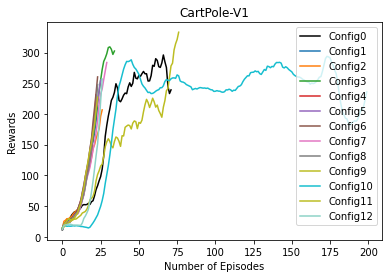

In [ ]:
scorescp = [scores_cp, scores1_cp, scores2_cp, scores3_cp,scores4_cp,scores5_cp,scores6_cp,scores7_cp,scores8_cp,scores9_cp,scores10_cp,scores11_cp,scores12_cp]
colors = ['#000000','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#bcbd22', '#8dd3c7']

for i in range(len(scorescp)):
  plt.plot(range(len(scorescp[i])), scorescp[i], color=colors[i], label=f'Config{i}')
plt.legend()
plt.xlabel('Number of Episodes')
plt.ylabel('Rewards')
plt.title("CartPole-V1")
plt.show()

# MountainCar-V0

Threshold reward: -150

Initial parameters:
* Architecture: 64, 64
* Buffer Size: 1e+5
* Batch Size: 64
* Learning Rate: 5e-4
* Update Frequency: 20
* Discount factor: 0.995

Num of episodes to reach threshold: 1433

In [ ]:
env_mc = gym.make('MountainCar-v0')
threshold_value_mc = -150

params_mc = {
    'hlayers' : [64, 64],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 64,
    'update_every' : 20,
    'policy' : 'e-greedy',
    'LR' : 5e-4
}

scores_mc, mountaincar_dqn, episode_mc = DQN(env_mc, threshold_value_mc, params_mc)
plt.plot(range(len(scores_mc)), scores_mc)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 0")
plt.show()

In [ ]:
params_mc1 = {
    'hlayers' : [128, 128],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 64,
    'update_every' : 20,
    'policy' : 'e-greedy',
    'LR' : 5e-4
}

scores_mc1, mountaincar_dqn1, episode_mc1 = DQN(env_mc, threshold_value_mc, params_mc1)
plt.plot(range(len(scores_mc1)), scores_mc1)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 1")
plt.show()

In [ ]:
params_mc2 = {
    'hlayers' : [512, 512],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 64,
    'update_every' : 20,
    'policy' : 'e-greedy',
    'LR' : 5e-4
}

scores_mc2, mountaincar_dqn2, episode_mc2 = DQN(env_mc, threshold_value_mc, params_mc2)
plt.plot(range(len(scores_mc2)), scores_mc2)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 2")
plt.show()

Episode 0	Average Score: -200.00
Episode 100	Average Score: -200.00
Episode 200	Average Score: -193.20
Episode 300	Average Score: -176.20
Episode 340	Average Score: -146.30
Environment solved in 340 episodes!	Average Score: -146.30


In [ ]:
params_mc3 = {
    'hlayers' : [64, 64, 64],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 64,
    'update_every' : 20,
    'policy' : 'e-greedy',
    'LR' : 5e-4
}

scores_mc3, mountaincar_dqn3, episode_mc3 = DQN(env_mc, threshold_value_mc, params_mc3)
plt.plot(range(len(scores_mc3)), scores_mc3)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 3")
plt.show()

Episode 0	Average Score: -200.00
Episode 100	Average Score: -200.00
Episode 200	Average Score: -200.00
Episode 300	Average Score: -200.00
Episode 400	Average Score: -200.00
Episode 500	Average Score: -200.00
Episode 590	Average Score: -148.20
Environment solved in 590 episodes!	Average Score: -148.20


In [ ]:
params_mc4 = {
    'hlayers' : [512, 512],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 64,
    'update_every' : 25,
    'policy' : 'e-greedy',
    'LR' : 5e-4
}

scores_mc4, mountaincar_dqn4, episode_mc4= DQN(env_mc, threshold_value_mc, params_mc4)
plt.plot(range(len(scores_mc4)), scores_mc4)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 4")
plt.show()

Episode 0	Average Score: -200.00
Episode 100	Average Score: -200.00
Episode 200	Average Score: -200.00
Episode 300	Average Score: -200.00
Episode 400	Average Score: -162.00
Episode 418	Average Score: -149.00
Environment solved in 418 episodes!	Average Score: -149.00


In [ ]:
params_mc5 = {
    'hlayers' : [512, 512],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 64,
    'update_every' : 15,
    'policy' : 'e-greedy',
    'LR' : 5e-4
}

scores_mc5, mountaincar_dqn5, episode_mc5 = DQN(env_mc, threshold_value_mc, params_mc5)
plt.plot(range(len(scores_mc5)), scores_mc5)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 5")
plt.show()

Episode 0	Average Score: -200.00
Episode 100	Average Score: -200.00
Episode 200	Average Score: -200.00
Episode 300	Average Score: -197.20
Episode 351	Average Score: -146.90
Environment solved in 351 episodes!	Average Score: -146.90


In [ ]:
params_mc6 = {
    'hlayers' : [512, 512],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 64,
    'update_every' : 20,
    'policy' : 'e-greedy',
    'LR' : 5e-3
}

scores_mc6, mountaincar_dqn6, episode_mc6 = DQN(env_mc, threshold_value_mc, params_mc6)
plt.plot(range(len(scores_mc6)), scores_mc6)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 6")
plt.show()

Episode 0	Average Score: -200.00
Episode 100	Average Score: -200.00
Episode 200	Average Score: -180.20
Episode 300	Average Score: -155.70
Episode 305	Average Score: -149.10
Environment solved in 305 episodes!	Average Score: -149.10


In [ ]:
params_mc7 = {
    'hlayers' : [512, 512],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 64,
    'update_every' : 20,
    'policy' : 'e-greedy',
    'LR' : 1e-3
}

scores_mc7, mountaincar_dqn7, episode_mc7 = DQN(env_mc, threshold_value_mc, params_mc7)
plt.plot(range(len(scores_mc7)), scores_mc7)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 7")
plt.show()

Episode 0	Average Score: -200.00
Episode 100	Average Score: -200.00
Episode 200	Average Score: -188.50
Episode 300	Average Score: -175.00
Episode 326	Average Score: -149.10
Environment solved in 326 episodes!	Average Score: -149.10


In [ ]:
params_mc8 = {
    'hlayers' : [512, 512],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 128,
    'update_every' : 20,
    'policy' : 'e-greedy',
    'LR' : 1e-3
}

scores_mc8, mountaincar_dqn8, episode_mc8 = DQN(env_mc, threshold_value_mc, params_mc8)
plt.plot(range(len(scores_mc8)), scores_mc8)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 8")
plt.show()

Episode 0	Average Score: -200.00
Episode 100	Average Score: -200.00
Episode 200	Average Score: -192.30
Episode 300	Average Score: -175.40
Episode 357	Average Score: -149.80
Environment solved in 357 episodes!	Average Score: -149.80


In [ ]:
params_mc9 = {
    'hlayers' : [512, 512],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 32,
    'update_every' : 20,
    'policy' : 'e-greedy',
    'LR' : 1e-3
}

scores_mc9, mountaincar_dqn9, episode_mc9 = DQN(env_mc, threshold_value_mc, params_mc9)
plt.plot(range(len(scores_mc9)), scores_mc9)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 9")
plt.show()

Episode 0	Average Score: -200.00
Episode 100	Average Score: -200.00
Episode 200	Average Score: -200.00
Episode 300	Average Score: -178.20
Episode 380	Average Score: -148.10
Environment solved in 380 episodes!	Average Score: -148.10


In [ ]:
params_mc10 = {
    'hlayers' : [512, 512],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 16,
    'update_every' : 20,
    'policy' : 'e-greedy',
    'LR' : 1e-3
}

scores_mc10, mountaincar_dqn10, episode_mc10 = DQN(env_mc, threshold_value_mc, params_mc10)
plt.plot(range(len(scores_mc10)), scores_mc10)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 10")
plt.show()

Episode 0	Average Score: -200.00
Episode 100	Average Score: -200.00
Episode 200	Average Score: -200.00
Episode 300	Average Score: -176.60
Episode 400	Average Score: -165.70
Episode 420	Average Score: -149.70
Environment solved in 420 episodes!	Average Score: -149.70


In [ ]:
params_mc11 = {
    'hlayers' : [512, 512, 128],
    'gamma' : 0.995,
    'buffer_size': 1e+5,
    'batch_size' : 64,
    'update_every' : 20,
    'policy' : 'e-greedy',
    'LR' : 1e-3
}

scores_mc11, mountaincar_dqn11, episode_mc11 = DQN(env_mc, threshold_value_mc, params_mc11)
plt.plot(range(len(scores_mc11)), scores_mc11)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 11")
plt.show()

Episode 0	Average Score: -200.00
Episode 100	Average Score: -200.00
Episode 200	Average Score: -200.00
Episode 300	Average Score: -174.00
Episode 400	Average Score: -176.70
Episode 419	Average Score: -148.70
Environment solved in 419 episodes!	Average Score: -148.70


In [ ]:
params_mc12 = {
    'hlayers' : [512, 512],
    'gamma' : 0.995,
    'buffer_size': 1e+4,
    'batch_size' : 16,
    'update_every' : 20,
    'policy' : 'e-greedy',
    'LR' : 1e-3
}

scores_mc12, mountaincar_dqn12, episode_mc12 = DQN(env_mc, threshold_value_mc, params_mc12)
plt.plot(range(len(scores_mc12)), scores_mc12)
plt.xlabel("Episodes")
plt.ylabel('Rewards')
plt.title("Config 12")
plt.show()

Episode 0	Average Score: -200.00
Episode 100	Average Score: -200.00
Episode 200	Average Score: -200.00
Episode 300	Average Score: -165.00
Episode 400	Average Score: -147.80

Environment solved in 400 episodes!	Average Score: -147.80


# Actor Critic
## Actor Critic model

In [29]:
class Actor_Critic_net(nn.Module):
  def __init__(self, params):
    super().__init__()
    self.input_size = params['input_size']
    self.action_size = params['action_size']
    self.hidden_layers = params['hlayers']

    self.layers = nn.ModuleList()

    cdim = self.input_size
    for hdim in self.hidden_layers:
      self.layers.append(nn.Linear(cdim, hdim))
      self.layers.append(nn.ReLU())
      cdim = hdim
    
    self.pi = nn.Linear(cdim, self.action_size)
    self.softmax = nn.Softmax()
    self.value = nn.Linear(cdim, 1)

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    
    pi = self.softmax(self.pi(x))
    v = self.value(x)
    return pi, v

class Container():
  def __init__(self):
    self.exp = namedtuple("Experience", ['state', 'action', 'reward', 'next_state', 'done'])
    self.memory = []
  
  def add(self, state, action, reward, next_state, done):
    exp = self.exp(state, action,  reward, next_state, done)
    self.memory.append(exp)
  
  def sample(self):
    states = torch.from_numpy(np.vstack([exp.state for exp in self.memory if exp.state is not None])).float()
    actions = torch.from_numpy(np.vstack([exp.action for exp in self.memory if exp.state is not None])).long()
    rewards = torch.from_numpy(np.vstack([exp.reward for exp in self.memory if exp.state is not None])).float()
    next_states = torch.from_numpy(np.vstack([exp.next_state for exp in self.memory if exp.state is not None])).float()
    dones = torch.from_numpy(np.vstack([exp.done for exp in self.memory if exp.state is not None])).float()

    return(states, actions, rewards, next_states, dones)
  
  def len(self):
    return len(self.memory)

  def empty(self):
    self.memory.clear()

## Agent

In [64]:
class Actor_Critic_Agent():
  def __init__(self, net_params, gamma, lr, n_step):
    self.gamma = gamma
    self.n_step = n_step
    self.network = Actor_Critic_net(net_params)
    self.optimizer = torch.optim.Adam(self.network.parameters(), lr = lr)

    self.memory = Container()
    

  def act(self, state):
    self.network.eval()
    with torch.no_grad():
      pi, _ = self.network(state)
    self.network.train()

    action_probs = torch.distributions.Categorical(probs= pi)
    return action_probs.sample().item()

  def full_step_return(self,  rewards):
    po = torch.pow(self.gamma, torch.arange(rewards.shape[0]))
    gamma_mat = torch.vstack([po * rewards.shape[0]])
    gamma_mat = torch.triu((gamma_mat.T / po).T)

    returns = gamma_mat @ rewards
    return returns
  
  def n_step_return(self, rewards):
    po = torch.pow(self.gamma, torch.arange(rewards.shape[0]))
    return po @ rewards

  def loss_n(self, states, actions, rewards, next_states, dones):
    pi, vs = self.network(states[0])
    _, vsn = self.network(states[-1])
    returns = self.n_step_return(rewards)

    delta = returns + (self.gamma ** rewards.shape[0]) * vsn - vs
    loss_actor = -torch.log(pi[actions[0]]) * delta
    loss_critic = delta ** 2

    loss_tot = loss_actor + loss_critic
    return loss_tot

  def loss_full(self, states, actions, rewards, next_states, dones):
    pi, vs = self.network(states)
    returns = self.full_step_return(rewards)

    delta = returns - vs
    loss_actor = -delta.T @ torch.log(pi.gather(1, actions))
    
    loss_critic = delta.T @ delta
    loss_tot = loss_actor + loss_critic
    return loss_tot

  def learn(self, exps):
    states, actions, rewards, next_states, dones = exps

    if self.n_step == -1:
      loss_tot = self.loss_full(states, actions, rewards, next_states, dones)
    else:
      loss_tot = self.loss_n(states, actions, rewards,next_states, dones)
    
    self.optimizer.zero_grad()
    loss_tot.backward()
    for param in self.network.parameters():
      param.grad.data.clamp(-1, 1)
    self.optimizer.step()

  def step(self, state, action, reward, next_state, done):
    self.memory.add(state, action, reward,  next_state, done)

    if self.n_step == -1 :
      if done:
        exps = self.memory.sample()
        self.learn(exps)
        self.memory.empty()

    else:
      if self.memory.len() == self.n_step:
        exps = self.memory.sample()
        self.learn(exps)
        self.memory.empty()

In [82]:
def Actor_Critic(env, thresh,  params, num_episodes = 10000, num_steps = 1000):
  state_space = env.observation_space.shape[0]
  action_space = env.action_space.n

  hlayers = params['hlayers']
  gamma = params['gamma']
  lr = params['lr']
  n_step = params['n_step']

  net_params = {
      'input_size' : state_space,
      'action_size' : action_space,
      'hlayers' : hlayers
  }

  scores = []
  avg_scores_10 = []
  steps_list = []

  agent = Actor_Critic_Agent(net_params, gamma, lr, n_step)

  for epi in range(num_episodes):
    state = env.reset()
    score = 0

    for step in range(num_steps):
      action = agent.act(torch.from_numpy(state))
      next_state, reward, done, _ = env.step(action)
      agent.step(state, action, reward, next_state, done)
      state = next_state
      score += reward
      if done:
        break
      

    scores.append(score)
    steps_list.append(step)

    if epi % 10:
      avg_scores_10.append(np.mean(scores[-10:]))
      print(f"\r Episode :{epi} Reward: {score} Avg Reward: {avg_scores_10[-1]}, Steps:{step}", end='')
      if avg_scores_10[-1] > thresh:
        print(f"Stopped at Episode {epi}")
        break
  return scores, avg_scores_10, agent, epi

# Acrobot-V1


In [83]:
env = gym.make("CartPole-v1")
threshold =  475

params_ab = {
    'hlayers' : [1024, 512],
    'gamma' : 0.995,
    'lr' : 1e-4,
    'n_step' : 1
}

scores_ab, avg_scores_ab, agent_ab, epi = Actor_Critic(env, threshold, params_ab)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-29-04a9854073c8>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = self.softmax(self.pi(x))


 Episode :176 Reward: 9.0 Avg Reward: 9.3, Steps:8

KeyboardInterrupt: ignored